**Корректность проверена на Python 3.6:**
+ numpy 1.15.4
+ matplotlib 3.0.2
+ seaborn 0.9.0
+ sklearn 0.20.2

# Сравнение метрик качества бинарной классификации
## Programming Assignment

В этом задании мы разберемся, в чем состоит разница между разными метриками качества. Мы остановимся на задаче бинарной классификации (с откликами 0 и 1), но рассмотрим ее как задачу предсказания вероятности того, что объект принадлежит классу 1. Таким образом, мы будем работать с вещественной, а не бинарной целевой переменной.

Задание оформлено в стиле демонстрации с элементами Programming Assignment. Вам нужно запустить уже написанный код и рассмотреть предложенные графики, а также реализовать несколько своих функций. Для проверки запишите в отдельные файлы результаты работы этих функций на указанных наборах входных данных, это можно сделать с помощью предложенных в заданиях функций write_answer_N, N - номер задачи. Загрузите эти файлы в систему.

Для построения графиков нужно импортировать соответствующие модули. 
Библиотека seaborn позволяет сделать графики красивее. Если вы не хотите ее использовать, закомментируйте третью строку.
Более того, для выполнения Programming Assignment модули matplotlib и seaborn не нужны (вы можете не запускать ячейки с построением графиков и смотреть на уже построенные картинки).

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn
%matplotlib inline

/Users/bs/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### Что предсказывают алгоритмы

Для вычисления метрик качества в обучении с учителем нужно знать только два вектора: вектор правильных ответов и вектор предсказанных величин; будем обозначать их actual и predicted. Вектор actual известен из обучающей выборки, вектор predicted возвращается алгоритмом предсказания. Сегодня мы не будем использовать какие-то алгоритмы классификации, а просто рассмотрим разные векторы предсказаний.

В нашей формулировке actual состоит из нулей и единиц, а predicted - из величин из интервала [0, 1] (вероятности класса 1). Такие векторы удобно показывать на scatter plot.

Чтобы сделать финальное предсказание (уже бинарное), нужно установить порог T: все объекты, имеющие предсказание выше порога, относят к классу 1, остальные - к классу 0. 

In [2]:
# рисует один scatter plot
def scatter(actual, predicted, T):
    plt.scatter(actual, predicted)
    plt.xlabel("Labels")
    plt.ylabel("Predicted probabilities")
    plt.plot([-0.2, 1.2], [T, T])
    plt.axis([-0.1, 1.1, -0.1, 1.1])
    
# рисует несколько scatter plot в таблице, имеющей размеры shape
def many_scatters(actuals, predicteds, Ts, titles, shape):
    plt.figure(figsize=(shape[1]*5, shape[0]*5))
    i = 1
    for actual, predicted, T, title in zip(actuals, predicteds, Ts, titles):
        ax = plt.subplot(shape[0], shape[1], i)
        ax.set_title(title)
        i += 1
        scatter(actual, predicted, T)

Идеальная ситуация: существует порог T, верно разделяющий вероятности, соответствующие двум классам. Пример такой ситуации:

In [3]:
actual_0 = np.array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  
          1.,  1.,  1., 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.])
predicted_0 = np.array([ 0.19015288,  0.23872404,  0.42707312,  0.15308362,  0.2951875 ,
            0.23475641,  0.17882447,  0.36320878,  0.33505476,  0.202608  ,
            0.82044786,  0.69750253,  0.60272784,  0.9032949 ,  0.86949819,
            0.97368264,  0.97289232,  0.75356512,  0.65189193,  0.95237033,
            0.91529693,  0.8458463 ])

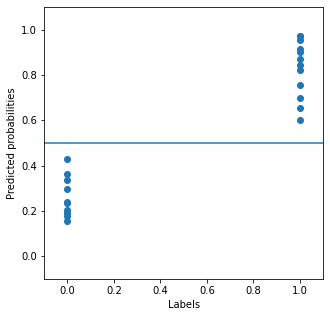

In [4]:
plt.figure(figsize=(5, 5))
scatter(actual_0, predicted_0, 0.5)

Интервалы вероятностей для двух классов прекрасно разделяются порогом T = 0.5.

Чаще всего интервалы накладываются - тогда нужно аккуратно подбирать порог. 

Самый неправильный алгоритм делает все наоборот: поднимает вероятности класса 0 выше вероятностей класса 1. Если так произошло, стоит посмотреть, не перепутались ли метки 0 и 1 при создании целевого вектора из сырых данных.

Примеры:

In [5]:
actual_1 = np.array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
                    0.,  0.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
                    1.,  1.,  1.,  1.])
predicted_1 = np.array([ 0.41310733,  0.43739138,  0.22346525,  0.46746017,  0.58251177,
            0.38989541,  0.43634826,  0.32329726,  0.01114812,  0.41623557,
            0.54875741,  0.48526472,  0.21747683,  0.05069586,  0.16438548,
            0.68721238,  0.72062154,  0.90268312,  0.46486043,  0.99656541,
            0.59919345,  0.53818659,  0.8037637 ,  0.272277  ,  0.87428626,
            0.79721372,  0.62506539,  0.63010277,  0.35276217,  0.56775664])
actual_2 = np.array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  0.,
            0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])
predicted_2 = np.array([ 0.07058193,  0.57877375,  0.42453249,  0.56562439,  0.13372737,
            0.18696826,  0.09037209,  0.12609756,  0.14047683,  0.06210359,
            0.36812596,  0.22277266,  0.79974381,  0.94843878,  0.4742684 ,
            0.80825366,  0.83569563,  0.45621915,  0.79364286,  0.82181152,
            0.44531285,  0.65245348,  0.69884206,  0.69455127])

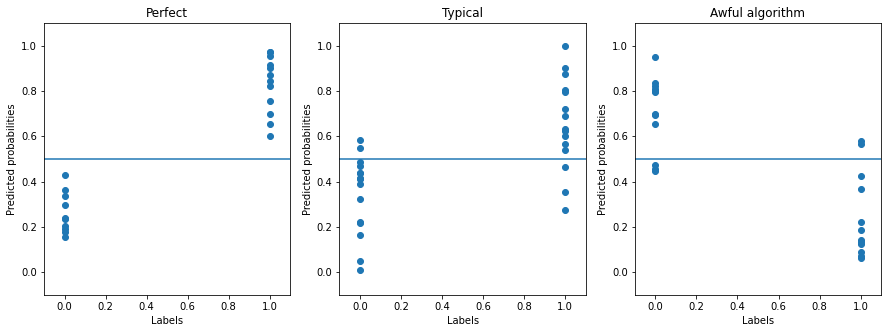

In [6]:
many_scatters([actual_0, actual_1, actual_2], [predicted_0, predicted_1, predicted_2], 
              [0.5, 0.5, 0.5], ["Perfect", "Typical", "Awful algorithm"], (1, 3))

Алгоритм может быть осторожным и стремиться сильно не отклонять вероятности от 0.5, а может рисковать - делать предсказания близакими к нулю или единице.  

In [7]:
# рискующий идеальный алгоитм
actual_0r = np.array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,
            1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.])
predicted_0r = np.array([ 0.23563765,  0.16685597,  0.13718058,  0.35905335,  0.18498365,
            0.20730027,  0.14833803,  0.18841647,  0.01205882,  0.0101424 ,
            0.10170538,  0.94552901,  0.72007506,  0.75186747,  0.85893269,
            0.90517219,  0.97667347,  0.86346504,  0.72267683,  0.9130444 ,
            0.8319242 ,  0.9578879 ,  0.89448939,  0.76379055])
# рискующий хороший алгоритм
actual_1r = np.array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,
            1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.])
predicted_1r = np.array([ 0.13832748,  0.0814398 ,  0.16136633,  0.11766141,  0.31784942,
            0.14886991,  0.22664977,  0.07735617,  0.07071879,  0.92146468,
            0.87579938,  0.97561838,  0.75638872,  0.89900957,  0.93760969,
            0.92708013,  0.82003675,  0.85833438,  0.67371118,  0.82115125,
            0.87560984,  0.77832734,  0.7593189,  0.81615662,  0.11906964,
            0.18857729])

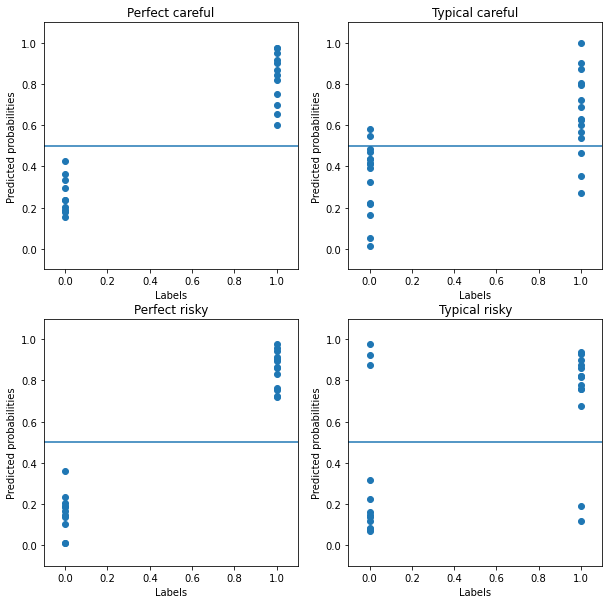

In [8]:
many_scatters([actual_0, actual_1, actual_0r, actual_1r], 
              [predicted_0, predicted_1, predicted_0r, predicted_1r], 
              [0.5, 0.5, 0.5, 0.5],
              ["Perfect careful", "Typical careful", "Perfect risky", "Typical risky"], 
              (2, 2))

Также интервалы могут смещаться. Если алгоритм боится ошибок false positive, то он будет чаще делать предсказания, близкие к нулю. 
Аналогично, чтобы избежать ошибок false negative, логично чаще предсказывать большие вероятности. 

In [9]:
actual_10 = np.array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
                0.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
                1.,  1.,  1.])
predicted_10 = np.array([ 0.29340574, 0.47340035,  0.1580356 ,  0.29996772,  0.24115457,  0.16177793,
                         0.35552878,  0.18867804,  0.38141962,  0.20367392,  0.26418924, 0.16289102, 
                         0.27774892,  0.32013135,  0.13453541, 0.39478755,  0.96625033,  0.47683139,  
                         0.51221325,  0.48938235, 0.57092593,  0.21856972,  0.62773859,  0.90454639,  0.19406537,
                         0.32063043,  0.4545493 ,  0.57574841,  0.55847795 ])
actual_11 = np.array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
                0.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.])
predicted_11 = np.array([ 0.35929566, 0.61562123,  0.71974688,  0.24893298,  0.19056711,  0.89308488,
            0.71155538,  0.00903258,  0.51950535,  0.72153302,  0.45936068,  0.20197229,  0.67092724,
                         0.81111343,  0.65359427,  0.70044585,  0.61983513,  0.84716577,  0.8512387 ,  
                         0.86023125,  0.7659328 ,  0.70362246,  0.70127618,  0.8578749 ,  0.83641841,  
                         0.62959491,  0.90445368])

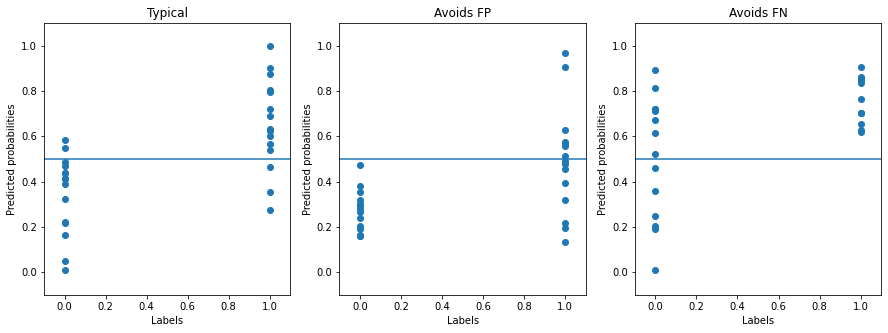

In [10]:
many_scatters([actual_1, actual_10, actual_11], [predicted_1, predicted_10, predicted_11], 
              [0.5, 0.5, 0.5], ["Typical", "Avoids FP", "Avoids FN"], (1, 3))

Мы описали разные характеры векторов вероятностей. Далее мы будем смотреть, как метрики оценивают разные векторы предсказаний, поэтому обязательно выполните ячейки, создающие векторы для визуализации.

### Метрики, оценивающие бинарные векторы предсказаний

Есть две типичные ситуации, когда специалисты по машинному обучению начинают изучать характеристики метрик качества: 
1. при участии в соревновании или решении прикладной задачи, когда вектор предсказаний оценивается по конкретной метрике, и нужно построить алгоритм, максимизирующий эту метрику.
1. на этапе формализации задачи машинного обучения, когда есть требования прикладной области, и нужно предложить математическую метрику, которая будет соответствовать этим требованиям.

Далее мы вкратце рассмотрим каждую метрику с этих двух позиций.

#### Precision и recall; accuracy

Для начала разберемся с метриками, оценивающие качество уже после бинаризации по порогу T, то есть сравнивающие два бинарных вектора: actual и predicted.

Две популярные метрики - precision и recall. Первая показывает, как часто алгоритм предсказывает класс 1 и оказывается правым, а вторая - как много объектов класса 1 алгоритм нашел. 

Также рассмотрим самую простую и известную метрику - accuracy; она показывает долю правильных ответов.

Выясним преимущества и недостатки этих метрик, попробовав их на разных векторах вероятностей.

In [11]:
from sklearn.metrics import precision_score, recall_score, accuracy_score

In [12]:
T = 0.5
print("Алгоритмы, разные по качеству:")
for actual, predicted, descr in zip([actual_0, actual_1, actual_2], 
                                    [predicted_0 > T, predicted_1 > T, predicted_2 > T],
                                    ["Perfect:", "Typical:", "Awful:"]):
    print(descr, "precision =", precision_score(actual, predicted), "recall =", \
        recall_score(actual, predicted), ";",\
        "accuracy =", accuracy_score(actual, predicted))
print()
print("Осторожный и рискующий алгоритмы:")
for actual, predicted, descr in zip([actual_1, actual_1r], 
                                    [predicted_1 > T, predicted_1r > T],
                                    ["Typical careful:", "Typical risky:"]):
    print(descr, "precision =", precision_score(actual, predicted), "recall =", \
        recall_score(actual, predicted), ";",\
        "accuracy =", accuracy_score(actual, predicted))
print()
print("Разные склонности алгоритмов к ошибкам FP и FN:")
for actual, predicted, descr in zip([actual_10, actual_11], 
                                    [predicted_10 > T, predicted_11 > T], 
                                    ["Avoids FP:", "Avoids FN:"]):
    print(descr, "precision =", precision_score(actual, predicted), "recall =", \
        recall_score(actual, predicted), ";",\
        "accuracy =", accuracy_score(actual, predicted))

Алгоритмы, разные по качеству:
Perfect: precision = 1.0 recall = 1.0 ; accuracy = 1.0
Typical: precision = 0.8571428571428571 recall = 0.8 ; accuracy = 0.8333333333333334
Awful: precision = 0.18181818181818182 recall = 0.16666666666666666 ; accuracy = 0.20833333333333334

Осторожный и рискующий алгоритмы:
Typical careful: precision = 0.8571428571428571 recall = 0.8 ; accuracy = 0.8333333333333334
Typical risky: precision = 0.8 recall = 0.8571428571428571 ; accuracy = 0.8076923076923077

Разные склонности алгоритмов к ошибкам FP и FN:
Avoids FP: precision = 1.0 recall = 0.4666666666666667 ; accuracy = 0.7241379310344828
Avoids FN: precision = 0.6190476190476191 recall = 1.0 ; accuracy = 0.7037037037037037


Все три метрики легко различают простые случаи хороших и плохих алгоритмов. Обратим внимание, что метрики имеют область значений  [0, 1], и потому их легко интерпретировать.

Метрикам не важны величины вероятностей, им важно только то, сколько объектов неправильно зашли за установленную границу (в данном случае T = 0.5).

Метрика accuracy дает одинаковый вес ошибкам false positive и false negative, зато пара метрик precision и recall однозначно идентифицирует это различие. Собственно, их для того и используют, чтобы контролировать ошибки FP и FN.

Мы измерили три метрики, фиксировав порог T = 0.5, потому что для почти всех картинок он кажется оптимальным. Давайте посмотрим на последней (самой интересной для этих метрик) группе векторов, как меняются precision и recall при увеличении порога.

In [13]:
from sklearn.metrics import precision_recall_curve

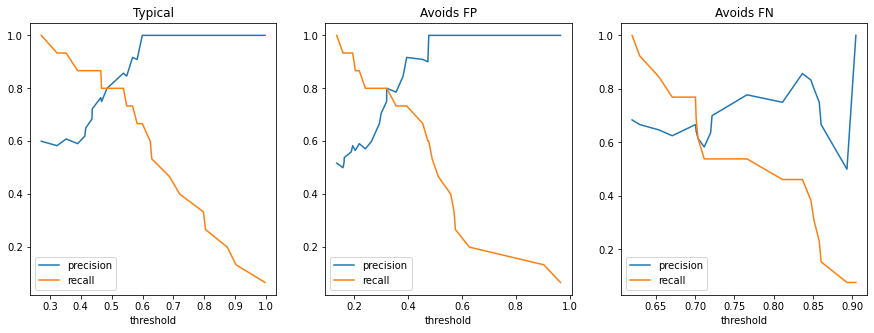

In [14]:
precs = []
recs = []
threshs = []
labels = ["Typical", "Avoids FP", "Avoids FN"]
for actual, predicted in zip([actual_1, actual_10, actual_11], 
                                    [predicted_1, predicted_10, predicted_11]):
    prec, rec, thresh = precision_recall_curve(actual, predicted)
    precs.append(prec)
    recs.append(rec)
    threshs.append(thresh)
plt.figure(figsize=(15, 5))
for i in range(3):
    ax = plt.subplot(1, 3, i+1)
    plt.plot(threshs[i], precs[i][:-1], label="precision")
    plt.plot(threshs[i], recs[i][:-1], label="recall")
    plt.xlabel("threshold")
    ax.set_title(labels[i])
    plt.legend()

При увеличении порога мы делаем меньше ошибок FP и больше ошибок FN, поэтому одна из кривых растет, а вторая  - падает. По такому графику можно подобрать оптимальное значение порога, при котором precision и recall будут приемлемы. Если такого порога не нашлось, нужно обучать другой алгоритм. 

Оговоримся, что приемлемые значения precision и recall определяются предметной областью. Например, в задаче определения, болен ли пациент определенной болезнью (0 - здоров, 1 - болен), ошибок false negative стараются избегать, требуя recall около 0.9. Можно сказать человеку, что он болен, и при дальнейшей диагностике выявить ошибку; гораздо хуже пропустить наличие болезни.

__<font color="green" size=5>Programming assignment: problem 1. </font>__ Фиксируем порог T = 0.65; по графикам можно примерно узнать, чему равны метрики на трех выбранных парах векторов (actual, predicted). Вычислите точные precision и recall для этих трех пар векторов.

6 полученных чисел запишите в текстовый файл в таком порядке:

precision_1 recall_1 precision_10 recall_10 precision_11 recall_11

Цифры XXX после пробела соответствуют таким же цифрам в названиях переменных actual_XXX и predicted_XXX.

Передайте ответ в функцию write_answer_1. Полученный файл загрузите в форму.

In [22]:
############### Programming assignment: problem 1 ###############
T = 0.65
answer_1 = []
for actual, predicted in zip([actual_1, actual_10, actual_11], [predicted_1 > T, predicted_10 > T, predicted_11 > T]):
    answer_1.append(precision_score(actual, predicted))
    answer_1.append(recall_score(actual, predicted))


In [23]:
def write_answer_1(precision_1, recall_1, precision_10, recall_10, precision_11, recall_11):
    answers = [precision_1, recall_1, precision_10, recall_10, precision_11, recall_11]
    with open("pa_metrics_problem1.txt", "w") as fout:
        fout.write(" ".join([str(num) for num in answers]))
write_answer_1(*answer_1)

#### F1-score

Очевидный недостаток пары метрик precision-recall - в том, что их две: непонятно, как ранжировать алгоритмы. Чтобы этого избежать, используют F1-метрику, которая равна среднему гармоническому precision и recall. 
F1-метрика будет равна 1, если и только если precision = 1 и recall = 1 (идеальный алгоритм). 

(: Обмануть F1 сложно: если одна из величин маленькая, а другая близка к 1 (по графикам видно, что такое соотношение иногда легко получить), F1 будет далека от 1. F1-метрику сложно оптимизировать, потому что для этого нужно добиваться высокой полноты и точности одновременно.

Например, посчитаем F1 для того же набора векторов, для которого мы строили графики (мы помним, что там одна из кривых быстро выходит в единицу).

In [24]:
from sklearn.metrics import f1_score

In [25]:
T = 0.5
print("Разные склонности алгоритмов к ошибкам FP и FN:")
for actual, predicted, descr in zip([actual_1, actual_10, actual_11], 
                                    [predicted_1 > T, predicted_10 > T, predicted_11 > T], 
                                    ["Typical:", "Avoids FP:", "Avoids FN:"]):
    print(descr, "f1 =", f1_score(actual, predicted))

Разные склонности алгоритмов к ошибкам FP и FN:
Typical: f1 = 0.8275862068965518
Avoids FP: f1 = 0.6363636363636364
Avoids FN: f1 = 0.7647058823529412


F1-метрика в двух последних случаях, когда одна из парных метрик равна 1, значительно меньше, чем в первом, сбалансированном случае.

__<font color="green" size=5>Programming assignment: problem 2. </font>__ На precision и recall влияют и характер вектора вероятностей, и установленный порог. 
Для тех же пар (actual, predicted), что и в предыдущей задаче, найдите оптимальные пороги, максимизирующие F1_score. Будем рассматривать только пороги вида T = 0.1 * k, k - целое; соответственно, нужно найти три значения k. Если f1 максимизируется при нескольких значениях k, укажите наименьшее из них.

Запишите найденные числа k в следующем порядке:

k_1, k_10, k_11

Цифры XXX после пробела соответствуют таким же цифрам в названиях переменных actual_XXX и predicted_XXX.

Передайте ответ в функцию write_answer_2. Загрузите файл в форму.

Если вы запишите список из трех найденных k в том же порядке в переменную ks, то с помощью кода ниже можно визуализировать найденные пороги:

In [34]:
############### Programming assignment: problem 2 ###############
def check_k():
    max_f_1 = (0, 0)
    max_f_10 = (0, 0)
    max_f_11 = (0, 0)
    for k in range(0, 10):
        f_1 = f1_score(actual_1, predicted_1 > 0.1*k)
        f_10 = f1_score(actual_10, predicted_10 > 0.1*k)
        f_11 = f1_score(actual_11, predicted_11 > 0.1*k)
        if f_1 > max_f_1[1]: max_f_1 = (k, f_1)
        if f_10 > max_f_10[1]: max_f_10 = (k, f_10)
        if f_11 > max_f_11[1]: max_f_11 = (k, f_11)
    return [max_f_1[0], max_f_10[0], max_f_11[0]]
check_k()   

[5, 3, 6]

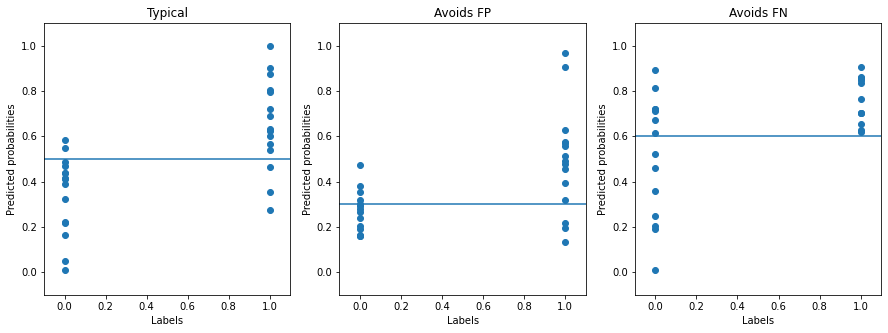

In [35]:
many_scatters([actual_1, actual_10, actual_11], [predicted_1, predicted_10, predicted_11], 
              np.array(check_k())*0.1, ["Typical", "Avoids FP", "Avoids FN"], (1, 3))

In [36]:
def write_answer_2(k_1, k_10, k_11):
    answers = [k_1, k_10, k_11]
    with open("pa_metrics_problem2.txt", "w") as fout:
        fout.write(" ".join([str(num) for num in answers]))
write_answer_2(*check_k())        

### Метрики, оценивающие векторы вероятностей класса 1

Рассмотренные метрики удобно интерпретировать, но при их использовании мы не учитываем большую часть информации, полученной от алгоритма. В некоторых задачах вероятности нужны в чистом виде, например, если мы предсказываем, выиграет ли команда в футбольном матче, и величина вероятности влияет на размер ставки за эту команду. Даже если в конце концов мы все равно бинаризуем предсказание, хочется следить за характером вектора вероятности. 

#### Log_loss

Log_loss вычисляет правдоподобие меток в actual с вероятностями из predicted, взятое с противоположным знаком:

$log\_loss(actual, predicted) = - \frac 1 n \sum_{i=1}^n (actual_i \cdot \log (predicted_i) + (1-actual_i) \cdot \log (1-predicted_i))$, $n$ - длина векторов.

Соответственно, эту метрику нужно минимизировать. 

Вычислим ее на наших векторах:

In [37]:
from sklearn.metrics import log_loss

In [39]:
print("Алгоритмы, разные по качеству:")
for actual, predicted, descr in zip([actual_0, actual_1, actual_2], 
                                    [predicted_0, predicted_1, predicted_2],
                                    ["Perfect:", "Typical:", "Awful:"]):
    print(descr, log_loss(actual, predicted))
print()
print("Осторожный и рискующий алгоритмы:")
for actual, predicted, descr in zip([actual_0, actual_0r, actual_1, actual_1r], 
                                    [predicted_0, predicted_0r, predicted_1, predicted_1r],
                                    ["Ideal careful", "Ideal risky", "Typical careful:", "Typical risky:"]):
    print(descr, log_loss(actual, predicted))
print()
print("Разные склонности алгоритмов к ошибкам FP и FN:")
for actual, predicted, descr in zip([actual_10, actual_11], 
                                    [predicted_10, predicted_11], 
                                    ["Avoids FP:", "Avoids FN:"]):
    print(descr, log_loss(actual, predicted))

Алгоритмы, разные по качеству:
Perfect: 0.24921263759186213
Typical: 0.4645068222557676
Awful: 1.5270248809234201

Осторожный и рискующий алгоритмы:
Ideal careful 0.24921263759186213
Ideal risky 0.17061947914666056
Typical careful: 0.4645068222557676
Typical risky: 0.6138745922344455

Разные склонности алгоритмов к ошибкам FP и FN:
Avoids FP: 0.5849339709893445
Avoids FN: 0.5886791288814904


Как и предыдущие метрики, log_loss хорошо различает идеальный, типичный и плохой случаи. Но обратите внимание, что интерпретировать величину достаточно сложно: метрика не достигает нуля никогда и не имеет верхней границы. Поэтому даже для идеального алгоритма, если смотреть только на одно значение log_loss, невозможно понять, что он идеальный.

Но зато эта метрика различает осторожный и рискующий алгоритмы. Как мы видели выше, в случаях Typical careful и Typical risky количество ошибок при бинаризации по T = 0.5 примерно одинаковое, в случаях Ideal ошибок вообще нет. Однако за неудачно угаданные классы в Typical рискующему алгоритму приходится платить большим увеличением log_loss, чем осторожному алгоритму. С другой стороны, за удачно угаданные классы рискованный идеальный алгоритм получает меньший log_loss, чем осторожный идеальный алгоритм.

Таким образом, log_loss чувствителен и к вероятностям, близким к 0 и 1, и к вероятностям, близким к 0.5. 

Ошибки FP и FN обычный Log_loss различать не умеет.

Однако нетрудно сделать обобщение log_loss на случай, когда нужно больше штрафовать FP или FN: для этого достаточно добавить выпуклую (то есть неотрицательную и суммирующуюся к единице) комбинацию из двух коэффициентов к слагаемым правдоподобия. Например, давайте штрафовать false positive:

$weighted\_log\_loss(actual, predicted) = -\frac 1 n \sum_{i=1}^n (0.3\, \cdot actual_i \cdot \log (predicted_i) + 0.7\,\cdot (1-actual_i)\cdot \log (1-predicted_i))$

Если алгоритм неверно предсказывает большую вероятность первому классу, то есть объект на самом деле принадлежит классу 0, то первое слагаемое в скобках равно нулю, а второе учитывается с большим весом.  

__<font color="green" size=5>Programming assignment: problem 3. </font>__ Напишите функцию, которая берет на вход векторы actual и predicted и возвращает модифицированный Log-Loss, вычисленный по формуле выше. Вычислите ее значение (обозначим его wll) на тех же векторах, на которых мы вычисляли обычный log_loss, и запишите в файл в следующем порядке:

wll_0 wll_1 wll_2 wll_0r wll_1r wll_10 wll_11

Цифры XXX после пробела соответствуют таким же цифрам в названиях переменных actual_XXX и predicted_XXX.

Передайте ответ в функцию write_answer3. Загрузите файл в форму.

In [44]:
from math import log
############### Programming assignment: problem 3 ###############
def 𝑤𝑒𝑖𝑔ℎ𝑡𝑒𝑑_𝑙𝑜𝑔_𝑙𝑜𝑠𝑠(𝑎𝑐𝑡𝑢𝑎𝑙,𝑝𝑟𝑒𝑑𝑖𝑐𝑡𝑒𝑑):
    sum = 0
    for i in range(len(𝑎𝑐𝑡𝑢𝑎𝑙)):
        sum += 0.3 *𝑎𝑐𝑡𝑢𝑎𝑙[i]* log(𝑝𝑟𝑒𝑑𝑖𝑐𝑡𝑒𝑑[i]) + 0.7 * (1-𝑎𝑐𝑡𝑢𝑎𝑙[i])*log(1-𝑝𝑟𝑒𝑑𝑖𝑐𝑡𝑒𝑑[i])
    return (-1 * sum) / len(𝑎𝑐𝑡𝑢𝑎𝑙)
wlls = []
for actual, predicted in zip([actual_0, actual_1, actual_2, actual_0r, actual_1r, actual_10, actual_11], 
                                    [predicted_0, predicted_1, predicted_2, predicted_0r, predicted_1r, predicted_10, predicted_11]):
    wlls.append(𝑤𝑒𝑖𝑔ℎ𝑡𝑒𝑑_𝑙𝑜𝑔_𝑙𝑜𝑠𝑠(actual, predicted))
wlls

[0.13125461813899456,
 0.23013509212543612,
 0.735079049383121,
 0.0841757752539052,
 0.3354478001273487,
 0.23785261402637706,
 0.3586659396151756]

In [45]:
def write_answer_3(wll_0, wll_1, wll_2, wll_0r, wll_1r, wll_10, wll_11):
    answers = [wll_0, wll_1, wll_2, wll_0r, wll_1r, wll_10, wll_11]
    with open("pa_metrics_problem3.txt", "w") as fout:
        fout.write(" ".join([str(num) for num in answers]))
write_answer_3(*wlls)

Обратите внимание на разницу weighted_log_loss между случаями Avoids FP и Avoids FN.

#### ROC и AUC

При построении ROC-кривой (receiver operating characteristic) происходит варьирование порога бинаризации вектора вероятностей, и  вычисляются величины, зависящие от числа ошибок FP и FN. Эти величины задаются так, чтобы в случае, когда существует порог для идеального разделения классов, ROC-кривая проходила через определенную точку - верхний левый угол квадрата [0, 1] x [0, 1]. Кроме того, она всегда проходит через левый нижний и правый верхний углы. Получается наглядная визуализация качества алгоритма. С целью охарактеризовать эту визуализацию численно, ввели понятие AUC - площадь под ROC-кривой.

Есть несложный и эффективный алгоритм, который за один проход по выборке вычисляет ROC-кривую и AUC, но мы не будем вдаваться в детали.

Построим ROC-кривые для наших задач:

In [48]:
from sklearn.metrics import roc_curve, roc_auc_score

Perfect:1.000000 Typical:0.884444 Awful:0.041667 Ideal careful:1.000000 Ideal Risky:1.000000 Typical careful:0.884444 Typical risky:0.738095 Typical:0.884444 Avoids FP:0.819048 Avoids FN:0.780220 


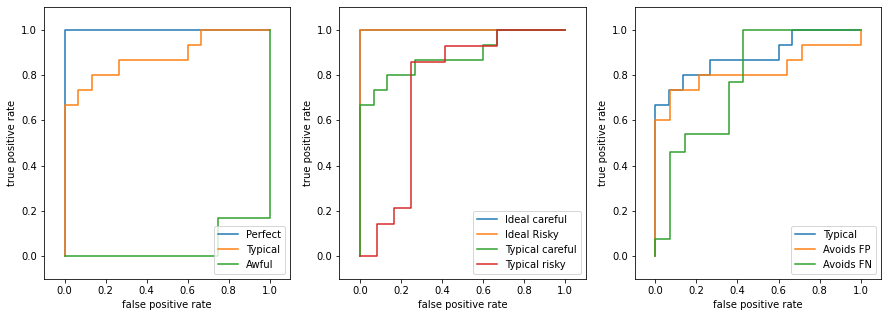

In [49]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
aucs = ""
for actual, predicted, descr in zip([actual_0, actual_1, actual_2], 
                                    [predicted_0, predicted_1, predicted_2],
                                    ["Perfect", "Typical", "Awful"]):
    fpr, tpr, thr = roc_curve(actual, predicted)
    plt.plot(fpr, tpr, label=descr)
    aucs += descr + ":%3f"%roc_auc_score(actual, predicted) + " "
plt.xlabel("false positive rate")
plt.ylabel("true positive rate")
plt.legend(loc=4)
plt.axis([-0.1, 1.1, -0.1, 1.1])
plt.subplot(1, 3, 2)
for actual, predicted, descr in zip([actual_0, actual_0r, actual_1, actual_1r], 
                                    [predicted_0, predicted_0r, predicted_1, predicted_1r],
                                    ["Ideal careful", "Ideal Risky", "Typical careful", "Typical risky"]):
    fpr, tpr, thr = roc_curve(actual, predicted)
    aucs += descr + ":%3f"%roc_auc_score(actual, predicted) + " "
    plt.plot(fpr, tpr, label=descr)
plt.xlabel("false positive rate")
plt.ylabel("true positive rate")
plt.legend(loc=4)
plt.axis([-0.1, 1.1, -0.1, 1.1])
plt.subplot(1, 3, 3)
for actual, predicted, descr in zip([actual_1, actual_10, actual_11], 
                                    [predicted_1, predicted_10, predicted_11], 
                                    ["Typical", "Avoids FP", "Avoids FN"]):
    fpr, tpr, thr = roc_curve(actual, predicted)
    aucs += descr + ":%3f"%roc_auc_score(actual, predicted) + " "
    plt.plot(fpr, tpr, label=descr)
plt.xlabel("false positive rate")
plt.ylabel("true positive rate")
plt.legend(loc=4)
plt.axis([-0.1, 1.1, -0.1, 1.1])
print(aucs)

Чем больше объектов в выборке, тем более гладкой выглядит кривая (хотя на самом деле она все равно ступенчатая).

Как и ожидалось, кривые всех идеальных алгоритмов проходят через левый верхний угол. На первом графике также показана типичная ROC-кривая (обычно на практике они не доходят до "идеального" угла). 

AUC рискующего алгоритма значительном меньше, чем у осторожного, хотя осторожный и рискущий идеальные алгоритмы не различаются по ROC или AUC. Поэтому стремиться увеличить зазор между интервалами вероятностей классов смысла не имеет.

Наблюдается перекос кривой в случае, когда алгоритму свойственны ошибки FP или FN. Однако по величине AUC это отследить невозможно (кривые могут быть симметричны относительно диагонали (0, 1)-(1, 0)). 

После того, как кривая построена, удобно выбирать порог бинаризации, в котором будет достигнут компромисс между FP или FN. Порог соответствует точке на кривой. Если мы хотим избежать ошибок FP, нужно выбирать точку на левой стороне квадрата (как можно выше), если FN - точку на верхней стороне квадрата (как можно левее). Все промежуточные точки будут соответствовать разным пропорциям FP и FN.

__<font color="green" size=5>Programming assignment: problem 4. </font>__ На каждой кривой найдите точку, которая ближе всего к левому верхнему углу (ближе в смысле обычного евклидова расстояния), этой точке соответствует некоторый порог бинаризации. Запишите в выходной файл пороги в следующем порядке:

T_0 T_1 T_2 T_0r T_1r T_10 T_11

Цифры XXX после пробела соответствуют таким же цифрам в названиях переменных actual_XXX и predicted_XXX.

Если порогов, минимизирующих расстояние, несколько, выберите __наибольший__.

Передайте ответ в функцию write_answer_4. Загрузите файл в форму.

Пояснение: функция roc_curve возвращает три значения: FPR (массив абсции точек ROC-кривой), TPR (массив ординат точек ROC-кривой) и thresholds (массив порогов, соответствующих точкам).

Рекомендуем отрисовывать найденную точку на графике с помощью функции plt.scatter.

In [53]:
############### Programming assignment: problem 4 ###############
Ts = []
for actual, predicted in zip([actual_0, actual_1, actual_2, actual_0r, actual_1r, actual_10, actual_11], 
                                    [predicted_0, predicted_1, predicted_2, predicted_0r, predicted_1r, predicted_10, predicted_11]):
    fpr, tpr, thr = roc_curve(actual, predicted)
    m = (100, 0)
    for i in range(len(fpr)):
        x = fpr[i]
        y = tpr[i]
        t = thr[i]
        delta = ((x)**2 + (1-y)**2)**0.5
        if delta < m[0]:
            m = (delta, t)
        if delta == m[0] and m[1] < t:
            m = (delta, t)
            
    Ts.append(m[1])
Ts

1.97368264
0.97368264
0.60272784
0.15308362
1.99656541
0.99656541
0.59919345
0.58251177
0.56775664
0.54875741
0.53818659
0.46746017
0.46486043
0.38989541
0.35276217
0.32329726
0.272277
0.01114812
1.94843878
0.94843878
0.65245348
0.56562439
0.44531285
0.06210359
1.9766734700000002
0.97667347
0.72007506
0.0101424
1.97561838
0.97561838
0.92708013
0.92146468
0.89900957
0.87579938
0.67371118
0.22664977
0.18857729
0.13832748
0.11906964
0.07071879
1.96625033
0.96625033
0.47683139
0.47340035
0.39478755
0.35552878
0.32063043
0.24115457
0.21856972
0.20367392
0.19406537
0.1580356
0.13453541
1.90445368
0.90445368
0.89308488
0.83641841
0.81111343
0.7659328
0.71155538
0.70044585
0.67092724
0.61983513
0.00903258


[0.60272784,
 0.53818659,
 1.94843878,
 0.72007506,
 0.67371118,
 0.39478755,
 0.70044585]

In [54]:
def write_answer_4(T_0, T_1, T_2, T_0r, T_1r, T_10, T_11):
    answers = [T_0, T_1, T_2, T_0r, T_1r, T_10, T_11]
    with open("pa_metrics_problem4.txt", "w") as fout:
        fout.write(" ".join([str(num) for num in answers]))
        
write_answer_4(*Ts)

Наподобие roc_curve, строят также precision-recall curve и ищут площадь под ней.

### Заключение

Мы рассмотрели несколько метрик бинарной классификации. Некоторые из них, например, log_loss, обобщаются на многоклассовый случай. Если метрику сложно обобщить в виде формулы, задачу многоклассовой классификации рассматривают как совокупность задач бинарной классификации и затем особыми способами усредняют метрику (например, micro и macro averaging).

На практике всегда полезно визуализировать векторы, которые выдает ваш алгоритм, чтобы понимать, какие он делает ошибки при разных порогах и как метрика реагирует на выдаваемые векторы предсказаний.